<img src="https://user-images.strikinglycdn.com/res/hrscywv4p/image/upload/c_limit,fl_lossy,h_300,w_300,f_auto,q_auto/1266110/Logo_wzxi0f.png" style="float: left; margin: 20px; height: 55px">

**Be less curious about people and more curious about ideas - [Marie Curie](https://en.wikipedia.org/wiki/Marie_Curie)**

# Chapter 10 Linear least squares

## 1. Least squares fit

Correlation coefficients measure the strength and sign of a relationship, but not the slope. There are several ways to estimate the slope; the most common is a **linear least squares** fit. A “linear fit” is a line intended to model the relationship between variables. A “least squares” fit is one that minimizes the mean squared error (MSE) between the line and the data.

Suppose we have a sequence of points, ys, that we want to express as a function of another sequence xs. If there is a linear relationship between xs and ys with intercept inter and slope slope, we expect each y[i] to be inter + slope * x[i].

But unless the correlation is perfect, this prediction is only approximate. The vertical deviation from the line, or **residual**, is

res = ys - (inter + slope * xs)

The residuals might be due to random factors like measurement error, or non-random factors that are unknown. For example, if we are trying to predict weight as a function of height, unknown factors might include diet, exercise,
and body type.

If we get the parameters inter and slope wrong, the residuals get bigger, so it makes intuitive sense that the parameters we want are the ones that minimize the residuals.

We might try to minimize the absolute value of the residuals, or their squares, or their cubes; but the most common choice is to minimize the sum of squared residuals, sum(res**2)).

Why? There are three good reasons and one less important one:

- Squaring has the feature of treating positive and negative residuals the same, which is usually what we want.

- Squaring gives more weight to large residuals, but not so much weight that the largest residual always dominates.

- If the residuals are uncorrelated and normally distributed with mean 0 and constant (but unknown) variance, then the least squares fit is also the maximum likelihood estimator of inter and slope. See https: //en.wikipedia.org/wiki/Linear_regression.

- The values of inter and slope that minimize the squared residuals can be computed efficiently.

The last reason made sense when computational efficiency was more important than choosing the method most appropriate to the problem at hand. That’s no longer the case, so it is worth considering whether squared residuals are the right thing to minimize.

For example, if you are using xs to predict values of ys, guessing too high might be better (or worse) than guessing too low. In that case you might want to compute some cost function for each residual, and minimize total
cost, sum(cost(res)). However, computing a least squares fit is quick, easy and often good enough.

## 2. Implementation

`thinkstats2` provides simple functions that demonstrate linear least squares:

In [1]:
from Resources.Think_Stats.Thinkstats2 import first

In [2]:
from Resources.Think_Stats.Thinkstats2 import thinkstats2
import numpy as np

In [3]:
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_lb

In [4]:
def LeastSquares(xs, ys):
    meanx, varx = thinkstats2.MeanVar(xs)
    meany = thinkstats2.Mean(ys)
    slope = thinkstats2.Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx
    return inter, slope

`LeastSquares` takes sequences xs and ys and returns the estimated parameters inter and slope. For details on how it works, see http://wikipedia.org/wiki/Numerical_methods_for_linear_least_squares.

`thinkstats2` also provides `FitLine`, which takes inter and slope and returns the fitted line for a sequence of xs.

In [5]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

Use these functions to compute the least squares fit for birth weight as a function of mother’s age:

In [6]:
#Code it here
inter, slope = LeastSquares(ages, weights)
print(inter, slope)

6.8303969733110526 0.017453851471802756


Draw a scatter plot of the two variables and plot a line on top of it.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

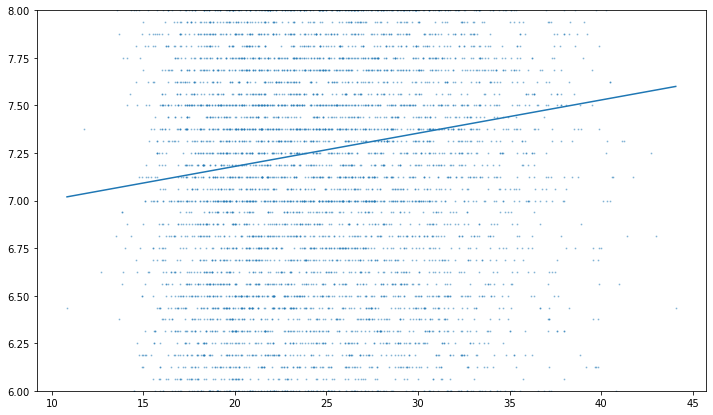

In [8]:
#Code it here
fit_xs, fit_ys = FitLine(ages, inter, slope)
# print(fit_xs, fit_ys)
plt.figure(figsize=(12,7))
plt.scatter(ages, weights, s=0.8, alpha=0.4)
plt.plot(fit_xs, fit_ys)
plt.ylim(6, 8)
plt.show()

In [9]:
age = inter + 6.5*slope
age

6.94384700787777

The estimated intercept and slope are 6.8 lbs and 0.017 lbs per year. These values are hard to interpret in this form: the intercept is the expected weight of a baby whose mother is 0 years old, which doesn’t make sense in context, and the slope is too small to grasp easily.

Instead of presenting the intercept at x = 0, it is often helpful to present the intercept at the mean of x. In this case the mean age is about 25 years and the mean baby weight for a 25 year old mother is 7.3 pounds. The slope is 0.27 ounces per year, or 0.17 pounds per decade.


## 3. Residuals

Another useful test is to plot the residuals.

Given two sequences xs, ys and the regression line with given inter and slope calculated before create a function that calculates the residuals. Knowing:

\begin{align}
res_i = y_i - (inter + slope * x_i)
\end{align}

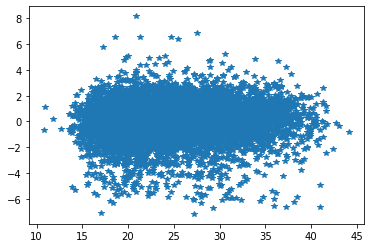

In [10]:
#Code it here
live['residual'] = weights - fit_ys
plt.plot(ages, live['residual'],'*')
plt.show()

To visualize the residuals, I'll split the respondents into groups by age, then plot the percentiles of the residuals versus the average age in each group.

First I'll make the groups and compute the average age in each group.

In [11]:
bins = np.arange(10, 48, 3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

age_means = [group.agepreg.mean() for _, group in groups][1:-1]
age_means

[15.212333333333312,
 17.74035928143719,
 20.506304824561838,
 23.455752212389893,
 26.435156146179903,
 29.411177432543294,
 32.30232530120497,
 35.240273631840736,
 38.10876470588231,
 40.91205882352941]

Next I'll compute the CDF of the residuals in each group.

In [12]:
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

The following function plots percentiles of the residuals against the average age in each group.

In [13]:
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)

The following figure shows the 25th, 50th, and 75th percentiles.

Curvature in the residuals suggests a non-linear relationship.

In [14]:
from Resources.Think_Stats.Thinkstats2 import thinkplot

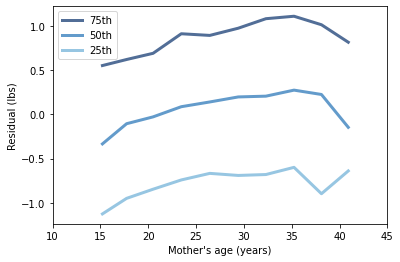

In [15]:
PlotPercentiles(age_means, cdfs)

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

To visualize the residuals, I group respondents by age and compute percentiles in each group. Then show the 25th, 50th and 75th percentiles of the residuals for each age group. The median is near zero, as expected, and the interquartile range is about 2 pounds. So if we know the mother’s age, we can guess the baby’s weight within a pound, about 50% of the time.

Ideally these lines should be flat, indicating that the residuals are random, and parallel, indicating that the variance of the residuals is the same for all age groups. In fact, the lines are close to parallel, so that’s good; but they have some curvature, indicating that the relationship is nonlinear. Nevertheless, the linear fit is a simple model that is probably good enough for some purposes.

## 4. Estimation

The parameters slope and inter are estimates based on a sample; like other estimates, they are vulnerable to sampling bias, measurement error, and sampling error. As discussed in Chapter 8, sampling bias is caused
by non-representative sampling, measurement error is caused by errors in collecting and recording data, and sampling error is the result of measuring a sample rather than the entire population.

To assess sampling error, we ask, “If we run this experiment again, how much variability do we expect in the estimates?” We can answer this question by running simulated experiments and computing sampling distributions of the estimates.

In order to you will simulate the experiments by resampling the data; that is, treating the observed pregnancies as if they were the entire population and draw samples, with replacement, from the observed sample.

Make a simulation recalculating slope and iter of 100 random picks from live data:

In [16]:
# Code it here

##Thinkstats resampling method is probably useful
inters = []
slopes = []

for _ in range(100):
    sample = thinkstats2.ResampleRows(live)    
    ages = sample.agepreg
    weights = sample.totalwgt_lb
    inter, slope = LeastSquares(ages, weights)
    inters.append(inter)
    slopes.append(slope)

After resampling, we use the simulated sample to estimate parameters. The result is two sequences: the estimated intercepts and estimated slopes. You can summarize the sampling distributions by printing the standard deviation and
confidence interval of the estimates:

In [17]:
#Code it here standard error = std / n
error_i = thinkstats2.Std(inters) 
error_s = thinkstats2.Std(slopes) 
print(error_i, error_s)

0.06633080377878775 0.002648154430762479


In [18]:
cdf_i = thinkstats2.Cdf(inters)
cdf_i.ConfidenceInterval(90)

(6.699234633050046, 6.927101151100491)

In [19]:
cdf_s = thinkstats2.Cdf(slopes)
cdf_s.ConfidenceInterval(90)

(0.013361285574223088, 0.02242823852397897)

The following function takes a list of estimates and prints the mean, standard error, and 90% confidence interval.

In [20]:
def Summarize(estimates, actual=None):
    mean = thinkstats2.Mean(estimates)
    stderr = thinkstats2.Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('Mean: ', mean)
    print('Std: ', stderr)
    print('CI: ', ci)

Here's  the summary for `inter`.

In [21]:
Summarize(inters)

Mean:  6.8289510312676605
Std:  0.06633080377878775
CI:  (6.699234633050046, 6.927101151100491)


And for `slope`.

In [22]:
Summarize(slopes)

Mean:  0.017501514239472885
Std:  0.002648154430762479
CI:  (0.013361285574223088, 0.02242823852397897)


For the intercept, the mean estimate is 6.83, with standard deviation 0.07 and 90% confidence interval (6.71, 6.94). The estimated slope, in more compact form, is 0.0174, SD 0.0028, CI (0.0126, 0.0220). There is almost a factor of
two between the low and high ends of this CI, so it should be considered a rough estimate.

To visualize the sampling error of the estimate, we could plot all of the fitted lines, or for a less cluttered representation, plot a 90% confidence interval for each age. Here’s the code:

In [23]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    
    for inter, slope in zip(inters, slopes):
        fxs, fys = thinkstats2.FitLine(xs, inter, slope)
        fys_seq.append(fys)
        
    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

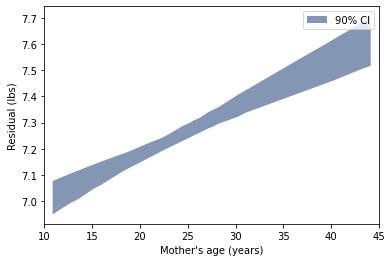

In [24]:
PlotConfidenceIntervals(live.agepreg, inters, slopes, label='90% CI')
thinkplot.Config(xlabel="Mother's age (years)",
                ylabel='Residual (lbs)',
                xlim=[10, 45])

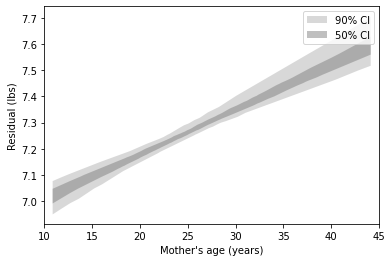

In [25]:
PlotConfidenceIntervals(live.agepreg, inters, slopes, percent=90,
                       color='gray', alpha=0.3, label='90% CI')
PlotConfidenceIntervals(live.agepreg, inters, slopes, percent=50,
                       color='gray', alpha=0.5, label='50% CI')

thinkplot.Config(xlabel="Mother's age (years)",
                ylabel='Residual (lbs)',
                xlim=[10, 45])

xs is the sequence of mother’s age. inters and slopes are the estimated parameters generated by Sampling Distributions. percent indicates which confidence interval to plot.

`PlotConfidenceIntervals` generates a fitted line for each pair of inter and slope and stores the results in a sequence, fys_seq. Then it uses `PercentileRows` to select the upper and lower percentiles of y for each value of x. For a 90% confidence interval, it selects the 5th and 95th percentiles. `FillBetween` draws a polygon that fills the space between two lines.

## 5. Goodness of fit

There are several ways to measure the quality of a linear model, or **goodness of fit**. One of the simplest is the standard deviation of the residuals.

If you use a linear model to make predictions, Std(res) is the root mean squared error (RMSE) of your predictions. For example, if you use mother’s age to guess birth weight. 

Guess now the weight of the baby with mother age as a guess and calculate the RMSE:

In [26]:
# Code it here
# This should be the other way around x=weights and y=ages
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg','totalwgt_lb'])
ages = live['agepreg']
weights = live['totalwgt_lb']

inter, slope = LeastSquares(ages, weights)
residuals = thinkstats2.Residuals(ages, weights, inter, slope)
rmse = thinkstats2.Std(residuals)
rmse

1.404875428785783

In [27]:
residuals.mean()

2.31134724843405e-16

If you guess birth weight without knowing the mother’s age, the RMSE of your guess is Std(ys), which is 1.41 lbs. So in this example, knowing a mother’s age does not improve the predictions substantially.

Another way to measure goodness of fit is the coefficient of determination, usually denoted R^2 and called **“R-squared”**:

In [28]:
def CoefDetermination(ys, res):
    return 1 - thinkstats2.Var(res) / thinkstats2.Var(ys)

Var(res) is the MSE of your guesses using the model, Var(ys) is the MSE without it. So their ratio is the fraction of MSE that remains if you use the model, and R^2 is the fraction of MSE the model eliminates.

What is the R^2 for birth weight and mother’s age? And how do you interpret it?

In [29]:
#Code it here
CoefDetermination(weights, residuals)

0.004738115474710702

There is a simple relationship between the coefficient of determination and Pearson’s coefficient of correlation: R^2 = ρ^2. For example, if ρ is 0.8 or -0.8, R^2 = 0.64.

Although ρ and R^2 are often used to quantify the strength of a relationship, they are not easy to interpret in terms of predictive power. In my opinion, Std(res) is the best representation of the quality of prediction, especially if it is presented in relation to Std(ys).

For example, when people talk about the validity of the SAT (a standardized test used for college admission in the U.S.) they often talk about correlations between SAT scores and other measures of intelligence.

According to one study, there is a Pearson correlation of ρ = 0.72 between total SAT scores and IQ scores, which sounds like a strong correlation. But R^2 = ρ^2 = 0.52, so SAT scores account for only 52% of variance in IQ.

IQ scores are normalized with Std(ys) = 15, so

In [30]:
import math

In [31]:
var_ys = 15**2
rho = 0.72
r2 = rho**2
var_res = (1 - r2) * var_ys
std_res = math.sqrt(var_res)

std_res

10.409610943738484

So using SAT score to predict IQ reduces RMSE from 15 points to 10.4 points. A correlation of 0.72 yields a reduction in RMSE of only 31%.

If you see a correlation that looks impressive, remember that R^2 is a better indicator of reduction in MSE, and reduction in RMSE is a better indicator of predictive power.

## 6. Testing a linear model

The effect of mother’s age on birth weight is small, and has little predictive power. So is it possible that the apparent relationship is due to chance? There are several ways we might test the results of a linear fit.

One option is to test whether the apparent reduction in MSE is due to chance. In that case, the test statistic is R^2 and the null hypothesis is that there is no relationship between the variables. We can simulate the null hypothesis by permutation, as in Section 9.5, when we tested the correlation between mother’s age and birth weight. In fact, because R^2 = ρ^2 , a one-sided test of R^2 is equivalent to a two-sided test of ρ. We’ve already done that test, and found p < 0.001, so we conclude that the apparent relationship between mother’s age and birth weight is statistically significant.

Another approach is to test whether the apparent slope is due to chance. The null hypothesis is that the slope is actually zero; in that case we can model the birth weights as random variations around their mean. Here’s a
HypothesisTest for this model:

In [32]:
class SlopeTest(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope
    
    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar
        
    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

The data are represented as sequences of ages and weights. The test statistic is the slope estimated by `LeastSquares`. The model of the null hypothesis is represented by the mean weight of all babies and the deviations from the mean. To generate simulated data, we permute the deviations and add them
to the mean.

In [33]:
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ht = SlopeTest((live.agepreg, live.totalwgt_lb))
pvalue = ht.PValue()
pvalue

0.0

The p-value is less than 0.001, so although the estimated slope is small, it is unlikely to be due to chance.

Estimating the p-value by simulating the null hypothesis is strictly correct, but there is a simpler alternative. Remember that we already computed the sampling distribution of the slope, in Section 10.4. To do that, we assumed
that the observed slope was correct and simulated experiments by resampling.

Before we calculated the sampling distribution of the slope, from Section 10.4, and the distribution of slopes generated under the null hypothesis. The sampling distribution is centered about the estimated slope, 0.017 lbs/year, and the slopes under the null hypothesis are centered around 0; but other than that, the distributions are identical. The distributions are also symmetric, for reasons we will see in Section 14.4.

So we could estimate the p-value two ways:

1. Compute the probability that the slope under the null hypothesis exceeds the observed slope.

2. Compute the probability that the slope in the sampling distribution falls below 0. (If the estimated slope were negative, we would compute the probability that the slope in the sampling distribution exceeds 0.)

The second option is easier because we normally want to compute the sampling distribution of the parameters anyway. And it is a good approximation unless the sample size is small and the distribution of residuals is skewed. Even then, it is usually good enough, because p-values don’t have to be precise.

Here’s the code that estimates the p-value of the slope using the sampling distribution:

In [34]:
def SamplingDistributions(live, iters=101):
    t = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = thinkstats2.LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

In [35]:
inters, slopes = SamplingDistributions(live, iters=1001)
slope_cdf = thinkstats2.Cdf(slopes)
pvalue = slope_cdf[0]
pvalue

0.0

Again, we find p < 0.001.

## 7. Weighted resampling

So far we have treated the NSFG data as if it were a representative sample, but as said in Chapter one it is not. The survey deliberately oversamples several groups in order to improve the chance of getting statistically
significant results; that is, in order to improve the power of tests involving these groups.

This survey design is useful for many purposes, but it means that we cannot use the sample to estimate values for the general population without accounting for the sampling process.

For each respondent, the NSFG data includes a variable called `finalwgt`, which is the number of people in the general population the respondent represents. This value is called a sampling weight, or just “weight.”

As an example, if you survey 100,000 people in a country of 300 million, each respondent represents 3,000 people. If you oversample one group by a factor of 2, each person in the oversampled group would have a lower weight, about
1500.

To correct for oversampling, we can use resampling; that is, we can draw samples from the survey using probabilities proportional to sampling weights. Then, for any quantity we want to estimate, we can generate sampling distributions, standard errors, and confidence intervals. As an example, I will estimate mean birth weight with and without sampling weights.

In Section 4, we saw `ResampleRows`, which chooses rows from a `DataFrame`, giving each row the same probability. Now we need to do the same thing using probabilities proportional to sampling weights. `ResampleRowsWeighted` takes a `DataFrame`, resamples rows according to the weights in `finalwgt`, and returns a `DataFrame` containing the resampled
rows:

In [36]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

`weights` is a Series; converting it to a dictionary makes a map from the indices to the weights. In `cdf` the values are indices and the probabilities are proportional to the weights.

`indices` is a sequence of row indices; `sample` is a DataFrame that contains the selected rows. Since we sample with replacement, the same row might appear more than once.

Now we can compare the effect of /resampling with and without weights. Without weights, we generate the sampling distribution like this:

In [37]:
iters = 100

In [38]:
estimates = [thinkstats2.ResampleRows(live).totalwgt_lb.mean()
            for _ in range(iters)]

With weights, it looks like this:

In [39]:
estimates_weighted = [ResampleRowsWeighted(live).totalwgt_lb.mean()
            for _ in range(iters)]

Calculate the mean of birth weight, the standard deviation and the 90% CI of both distributions:

In [40]:
mean_no_w = np.mean(estimates)
mean_w = np.mean(estimates_weighted)
std_no_w = thinkstats2.Std(estimates)
std_w = thinkstats2.Std(estimates_weighted)
cdf_1 = thinkstats2.Cdf(estimates)
cdf_2 = thinkstats2.Cdf(estimates_weighted)
ci_no_w = cdf_1.ConfidenceInterval(90)
ci_w = cdf_2.ConfidenceInterval(90)

In [41]:
print(f"mean_no_w: {mean_no_w}")
print(f"mean_w: {mean_w}")
print(f"std_no_w: {std_no_w}")
print(f"std_w: {std_w}")
print(f"ci_no_w: {ci_no_w}")
print(f"ci_w: {ci_w}")

mean_no_w: 7.265643117946448
mean_w: 7.3481548738659
std_no_w: 0.014581630198049655
std_w: 0.014314896880036539
ci_no_w: (7.241722449657003, 7.287957789333923)
ci_w: (7.3240968687762775, 7.366597975215756)


The following table summarizes the results:

![alt text](Resources/Think_Stats/notebookpics/table_resa.png "Title")
    
In this example, the effect of weighting is small but non-negligible. The difference in estimated means, with and without weighting, is about 0.08 pounds, or 1.3 ounces. This difference is substantially larger than the standard error of the estimate, 0.014 pounds, which implies that the difference is not due to chance.